TIme Series Forecast with NHiTS on the Vierlinden dataset (all sensors, 2021)

In [1]:
import sys
sys.path.append('./pytorch-forecasting/')
import pandas as pd
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, TQDMProgressBar,StochasticWeightAveraging
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss, MAE, RMSE

/storage/.venv/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Load data

Split in train and validation

In [2]:
# Read the dataset into a DataFrame
data = pd.read_csv('../../data/Vierlinden/Vierlinden_2021_Complete.csv')

# Set Datetime as index
data['Datetime'] = pd.to_datetime(data['Datetime'])

In [3]:
# One time series for every month?
#data['series'] = data['Datetime'].dt.year*12 + data['Datetime'].dt.month
#data['series'] -= data['series'].min()

# One time series for every 5 days?
#data['series'] = pd.Series([h for h in range(73) for _ in range(24*5)])

# One time series for the whole year?
data['series'] = 0

# As many timesteps per timeseries as hours in every month?
time_idx = []
for i in range(1):
    timesteps = len( data[ data['series'] == i ] )
    time_idx += list(range(timesteps))
data['time_idx'] = time_idx
data

,Datetime,Schieber Position_pval,Oberwasser_pval,Unterwasser_pval,Durchflumenge_pval,Berechnete Durchflussmenge_pval,Fllstand SWS_pval,Fllstand RWS_pval,Strom P1_pval,Strom P2_pval,...,Niederschlag,Füllstand_RRB,Entleerung_RüB,Füllstand_RüB_1,Füllstand_RüB_2,Füllstand_RüB_3,Kreuzweg_outflow [l/s],Kaiserstr_outflow [l/s],series,time_idx
0,2021-01-04 06:00:00,100.0,7.785714,5.000000,4.955882,7.933333,75.717949,36.0,1.076923,0.0,...,0.0,1.47,0.099,3.16,3.08,2.72,0.0,0.0,0,0
1,2021-01-04 07:00:00,100.0,8.228571,5.479452,6.455882,8.857143,75.383333,36.0,1.383333,0.0,...,0.0,1.47,0.098,3.16,3.08,2.72,0.0,0.0,0,1
2,2021-01-04 08:00:00,100.0,8.861538,5.967742,8.216216,9.638298,75.233333,36.0,1.400000,0.0,...,0.0,1.47,0.100,3.16,3.08,2.72,0.0,0.0,0,2
3,2021-01-04 09:00:00,100.0,11.410959,7.686567,9.597561,14.582418,76.216667,36.0,1.500000,0.0,...,0.0,1.47,0.098,3.16,3.08,2.72,0.0,0.0,0,3
4,2021-01-04 10:00:00,100.0,9.610390,6.714286,11.222222,10.470000,74.700000,36.0,1.933333,0.0,...,0.0,1.47,0.099,3.16,3.08,2.72,0.0,0.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8677,2021-12-31 19:00:00,99.0,9.859155,6.147541,9.347222,12.800000,75.033333,35.0,1.700000,0.0,...,0.0,1.06,0.181,1.15,1.29,0.62,0.0,0.0,0,8677
8678,2021-12-31 20:00:00,99.0,9.111111,5.823529,7.970588,11.211268,76.000000,35.0,1.300000,0.0,...,0.0,1.06,0.179,1.15,1.29,0.62,0.0,0.0,0,8678
8679,2021-12-31 21:00:00,99.0,11.652778,7.544118,16.804878,17.802326,74.250000,35.0,1.600000,0.0,...,0.0,1.06,0.183,1.15,1.29,0.62,0.0,0.0,0,8679
8680,2021-12-31 22:00:00,99.0,8.338028,5.287671,7.107692,9.878788,76.200000,35.0,1.233333,0.0,...,0.0,1.06,0.186,1.15,1.29,0.62,0.0,0.0,0,8680


In [5]:
target_variable = 'Kaiserstr_outflow [l/s]'

# Filter out columns that contain other target variables than the one we want to predict
if target_variable == 'Kaiserstr_outflow [l/s]':
    data = data.drop(['Entleerung_RüB', 'Füllstand_RüB_1', 'Füllstand_RüB_2', 'Füllstand_RüB_3', 'Kreuzweg_outflow [l/s]'], axis=1)
elif target_variable == 'Kreuzweg_outflow [l/s]':
    data = data.drop(['Entleerung_RüB', 'Füllstand_RüB_1', 'Füllstand_RüB_2', 'Füllstand_RüB_3', 'Kaiserstr_outflow [l/s]'], axis=1)
else:
    raise ValueError('Unknown target variable')

data.head()

In [7]:
# Create dataloaders
max_encoder_length = 24*2
max_prediction_length = 5*2
#training_cutoff = data["time_idx"].max() - max_prediction_length #20*max_prediction_length
training_cutoff = data["time_idx"].max() * 4 // 5 # 80% for training
# Note: if you just subtract 1*max_prediction_length, some of the time series (for some of the months) will not be computed

context_length = max_encoder_length
prediction_length = max_prediction_length

# Note: NBeats can only handle one target
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    #scalers={}, # each real variable stored under time_varying..._reals is scaled as default with sklearn.StandardScaler
    target_normalizer="auto",
    time_idx="time_idx",
    target="Kreuzweg_outflow [l/s]",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=list(set(data.columns) - {'Datetime', 'series', 'time_idx'}),
    #time_varying_known_reals=['time_idx'], # doesn't work for NHits, only TFT
    max_encoder_length=context_length,
    min_encoder_length=max_encoder_length,
    max_prediction_length=prediction_length,
    min_prediction_length=max_prediction_length,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 32

training   = training.load('../splits/train_set_without_timeidx')
validation = validation.load('../splits/val_set_without_timeidx')

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=18)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=18)

# Save training and validation sets to disk
# Otherwise, whenever recreating the datasets for inference, TimeSeriesDataSet will randomly permute the columns
#training.save('./RIWWER/Vierlinden/train_set_with_timeidx')
#validation.save('./RIWWER/Vierlinden/val_set_with_timeidx')

/storage/.venv/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/storage/.venv/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Baseline

In [8]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(torch.device('cuda:0'))
predictions = Baseline().predict(val_dataloader)

err = actuals - predictions
mae = err.abs().mean()
print('MAE = ' + str(mae))
rmse = torch.sqrt( torch.square(err).mean() )
print('RMSE = ' + str(rmse))

/storage/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/storage/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE = tensor(1.7076, device='cuda:0')
RMSE = tensor(10.2045, device='cuda:0')


### Training

In [9]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="gpu",
                     devices = 1,
                     max_epochs = 20,
                     gradient_clip_val=0.01,
                     logger = False)
net = NHiTS.from_dataset(training,
                         learning_rate=3e-2, weight_decay=1e-2,
                         #loss=QuantileLoss())
                         backcast_loss_ratio=1.0)
# Note: 'widths' denotes the width of each forecasting block. By default, the first forecasts the trend, while the second forecasts seasonality.
# Note: comment out backcast_loss_ratio when using QuantileLoss()

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/storage/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/storage/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 29.47it/s]
Learning rate set to 7.07945784384138e-05
Restoring states from the checkpoint path at /storage/UT_RIWWER_project/notebooks/.lr_find_34ccd0b0-047b-436b-b23f-a477eb4cb616.ckpt
Restored all states from the checkpoint at /storage/UT_RIWWER_project/notebooks/.lr_find_34ccd0b0-047b-436b-b23f-a477eb4cb616.ckpt


suggested learning rate: 7.07945784384138e-05


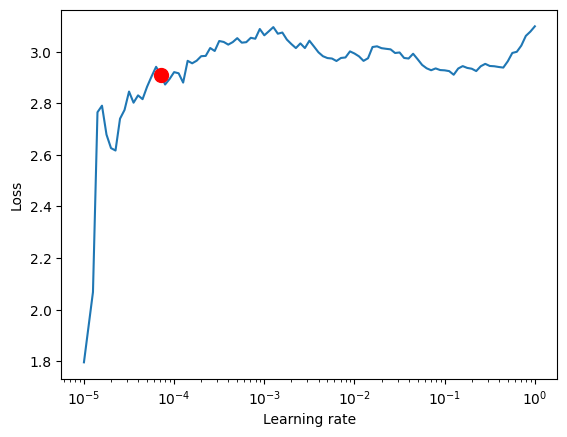

In [10]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net,
                             train_dataloaders=train_dataloader,
                             val_dataloaders=val_dataloader,
                             min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

Fit model

In [11]:
pl.seed_everything(42)
early_stop = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_sched = StochasticWeightAveraging(swa_lrs=res.suggestion(),swa_epoch_start=5, device=torch.device('cuda:0'))
lr_logger = LearningRateMonitor(logging_interval='step')  # log the learning rate ('step' or 'epoch')
logger = TensorBoardLogger("./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_saved_datasets")  # logging results to a tensorboard
# at this path, a folder with the name lightning_logs is searched for; if not found, it is created

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop, lr_logger, TQDMProgressBar(), lr_sched],
    limit_train_batches=150,
    log_every_n_steps=5,
    logger=logger
)

net = NHiTS.from_dataset(
    training,
    learning_rate=res.suggestion(),
    #loss=QuantileLoss(),
    dropout=0.1,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    #ckpt_path="./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_saved_datasets/lightning_logs/version_2/checkpoints/epoch=99-step=15000.ckpt"
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params
---------------------------------------------------
0 | loss            | MASE           | 0     
1 | logging_metrics | ModuleList     | 0     
2 | embeddings      | MultiEmbedding | 0     
3 | model           | NHiTS          | 914 K 
---------------------------------------------------
914 K     Trainable params
0         Non-trainable params
914 K     Total params
3.658     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 150/150 [00:32<00:00,  4.68it/s, v_num=1, train_loss_step=3.100, val_loss=2.540, train_loss_epoch=3.190]

Metric val_loss improved. New best score: 2.538


Epoch 1: 100%|██████████| 150/150 [00:30<00:00,  4.85it/s, v_num=1, train_loss_step=2.460, val_loss=2.490, train_loss_epoch=3.050]

Metric val_loss improved by 0.048 >= min_delta = 0.0001. New best score: 2.490


Epoch 2: 100%|██████████| 150/150 [00:32<00:00,  4.62it/s, v_num=1, train_loss_step=4.130, val_loss=2.460, train_loss_epoch=2.950]

Metric val_loss improved by 0.026 >= min_delta = 0.0001. New best score: 2.464


Epoch 3: 100%|██████████| 150/150 [00:32<00:00,  4.65it/s, v_num=1, train_loss_step=2.200, val_loss=2.460, train_loss_epoch=2.830]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 2.456


Epoch 4:   0%|          | 0/150 [00:00<?, ?it/s, v_num=1, train_loss_step=2.200, val_loss=2.460, train_loss_epoch=2.830]          

Swapping scheduler `ReduceLROnPlateau` for `SWALR`


Epoch 4: 100%|██████████| 150/150 [00:33<00:00,  4.48it/s, v_num=1, train_loss_step=3.980, val_loss=2.440, train_loss_epoch=2.880]

Metric val_loss improved by 0.013 >= min_delta = 0.0001. New best score: 2.443


Epoch 5: 100%|██████████| 150/150 [00:32<00:00,  4.66it/s, v_num=1, train_loss_step=2.920, val_loss=2.430, train_loss_epoch=2.830]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 2.435


Epoch 6: 100%|██████████| 150/150 [00:34<00:00,  4.37it/s, v_num=1, train_loss_step=3.950, val_loss=2.430, train_loss_epoch=2.810]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.430


Epoch 7: 100%|██████████| 150/150 [00:35<00:00,  4.21it/s, v_num=1, train_loss_step=4.500, val_loss=2.430, train_loss_epoch=2.740]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.427


Epoch 9: 100%|██████████| 150/150 [00:35<00:00,  4.17it/s, v_num=1, train_loss_step=1.600, val_loss=2.420, train_loss_epoch=2.720]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 2.417


Epoch 10: 100%|██████████| 150/150 [00:32<00:00,  4.62it/s, v_num=1, train_loss_step=3.950, val_loss=2.410, train_loss_epoch=2.750]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 2.409


Epoch 11: 100%|██████████| 150/150 [00:32<00:00,  4.65it/s, v_num=1, train_loss_step=2.340, val_loss=2.400, train_loss_epoch=2.640]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.403


Epoch 14: 100%|██████████| 150/150 [00:32<00:00,  4.67it/s, v_num=1, train_loss_step=2.900, val_loss=2.400, train_loss_epoch=2.660]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.399


Epoch 15: 100%|██████████| 150/150 [00:39<00:00,  3.80it/s, v_num=1, train_loss_step=2.890, val_loss=2.390, train_loss_epoch=2.600]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.393


Epoch 17: 100%|██████████| 150/150 [00:34<00:00,  4.38it/s, v_num=1, train_loss_step=2.650, val_loss=2.390, train_loss_epoch=2.590]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.391


Epoch 19: 100%|██████████| 150/150 [00:41<00:00,  3.63it/s, v_num=1, train_loss_step=1.690, val_loss=2.390, train_loss_epoch=2.500]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 2.390


Epoch 20: 100%|██████████| 150/150 [00:34<00:00,  4.34it/s, v_num=1, train_loss_step=1.680, val_loss=2.390, train_loss_epoch=2.520]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 2.390


Epoch 30: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s, v_num=1, train_loss_step=1.760, val_loss=2.390, train_loss_epoch=2.510]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.386


Epoch 34: 100%|██████████| 150/150 [00:37<00:00,  3.95it/s, v_num=1, train_loss_step=4.330, val_loss=2.380, train_loss_epoch=2.450]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.381


Epoch 44: 100%|██████████| 150/150 [00:39<00:00,  3.76it/s, v_num=1, train_loss_step=2.300, val_loss=2.390, train_loss_epoch=2.430]

Monitored metric val_loss did not improve in the last 10 records. Best score: 2.381. Signaling Trainer to stop.


Epoch 44: 100%|██████████| 150/150 [00:40<00:00,  3.72it/s, v_num=1, train_loss_step=2.300, val_loss=2.390, train_loss_epoch=2.430]


In [12]:
trainer.save_checkpoint("../../model_checkpoints/NHits_Vierlinden_Kreuzweg.ckpt")

In [ ]:
model = NHiTS.load_from_checkpoint("../../model_checkpoints/NHits_Vierlinden_Kreuzweg.ckpt")

## NHits with MASE

### Evaluation

In [13]:
trainer.callback_metrics

{'train_loss': tensor(2.4309),
 'train_loss_step': tensor(2.2959),
 'train_backcast_loss': tensor(0.2152),
 'train_backcast_loss_step': tensor(0.1912),
 'train_forecast_loss': tensor(2.4309),
 'train_forecast_loss_step': tensor(2.2959),
 'val_backcast_loss': tensor(0.1839),
 'val_forecast_loss': tensor(2.3876),
 'val_loss': tensor(2.3876),
 'val_SMAPE': tensor(0.4347),
 'val_MAE': tensor(1.3550),
 'val_RMSE': tensor(3.1744),
 'val_MAPE': tensor(490754.4688),
 'val_MASE': tensor(2.3876),
 'train_loss_epoch': tensor(2.4309),
 'train_backcast_loss_epoch': tensor(0.2152),
 'train_forecast_loss_epoch': tensor(2.4309)}

In [14]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_model = NHiTS.load_from_checkpoint(best_model_path)

./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_saved_datasets/lightning_logs/version_1/checkpoints/epoch=44-step=6750.ckpt


/storage/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/storage/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [15]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(torch.device('cuda:0')) # actuals were on CPU per default
predictions = best_model.predict(val_dataloader,
                                 trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_saved_datasets"))
(actuals - predictions).abs().mean()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(1.3550, device='cuda:0')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


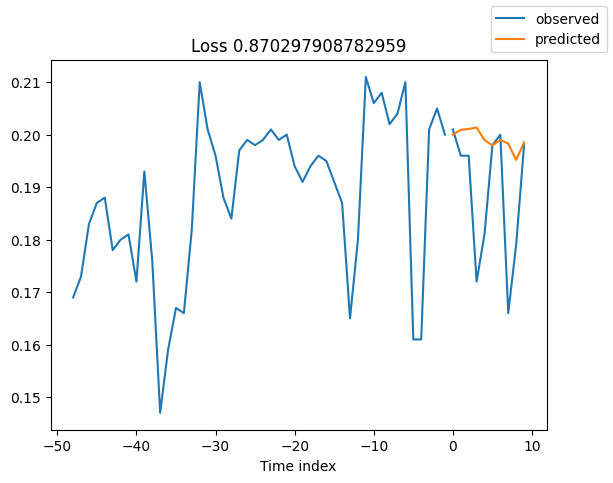

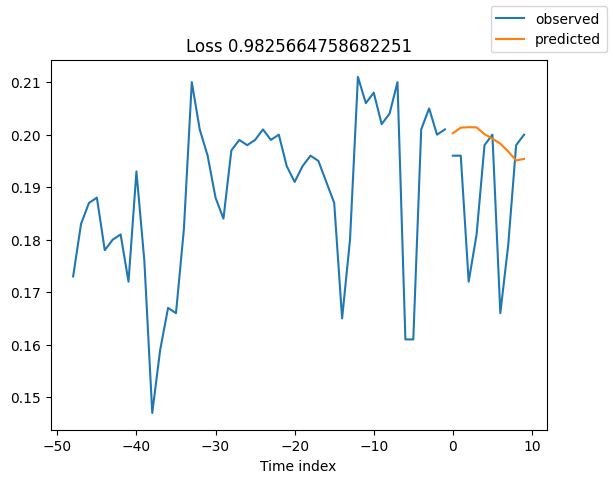

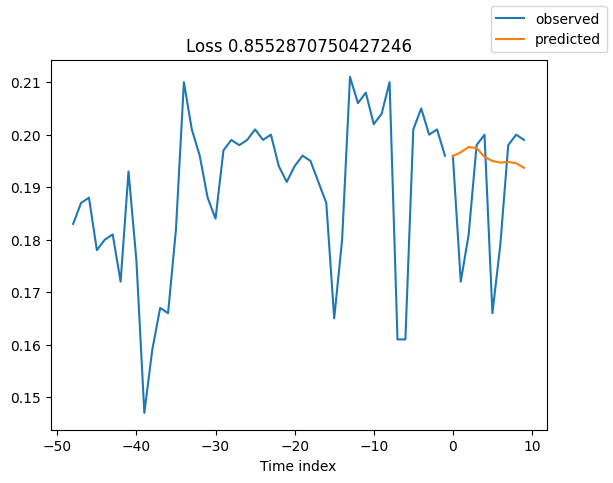

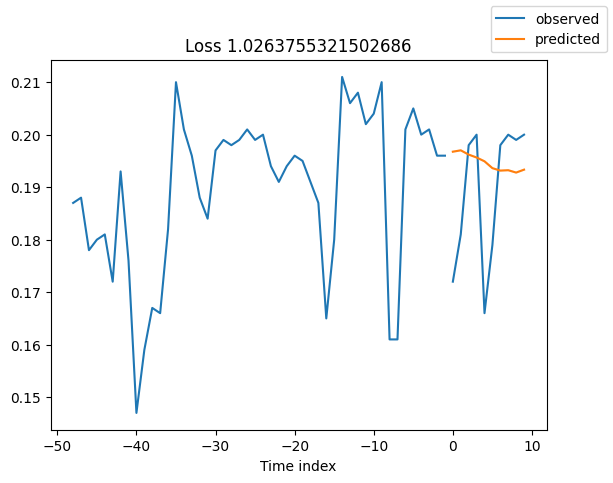

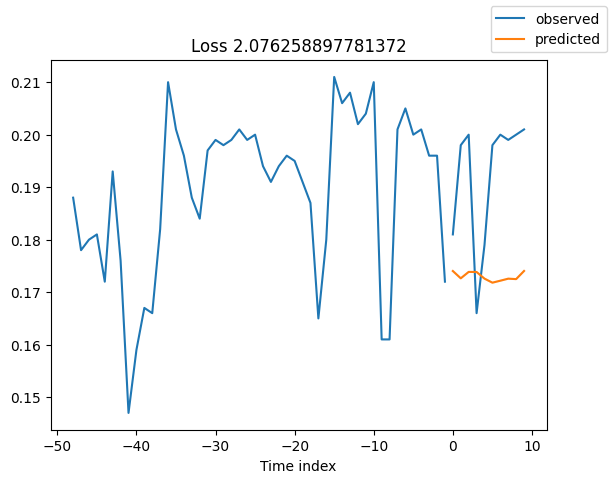

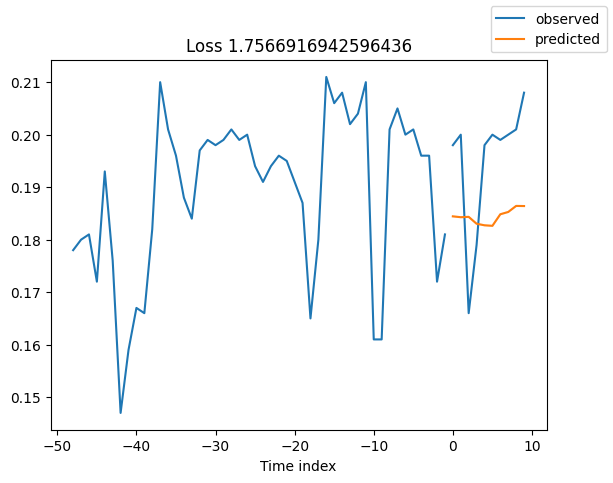

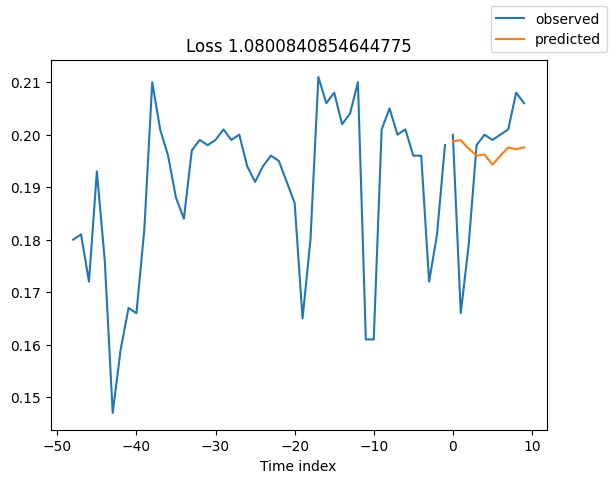

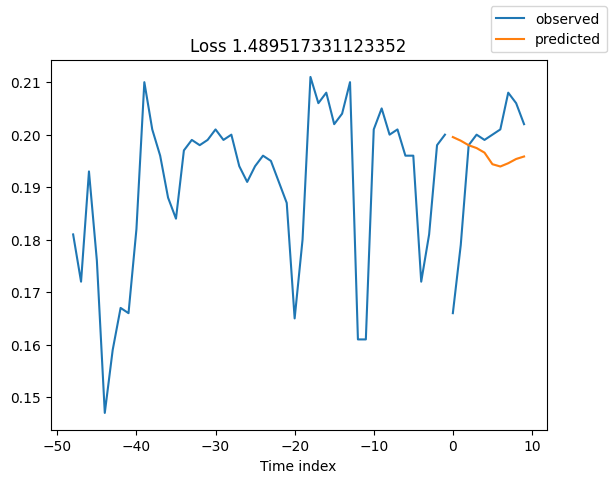

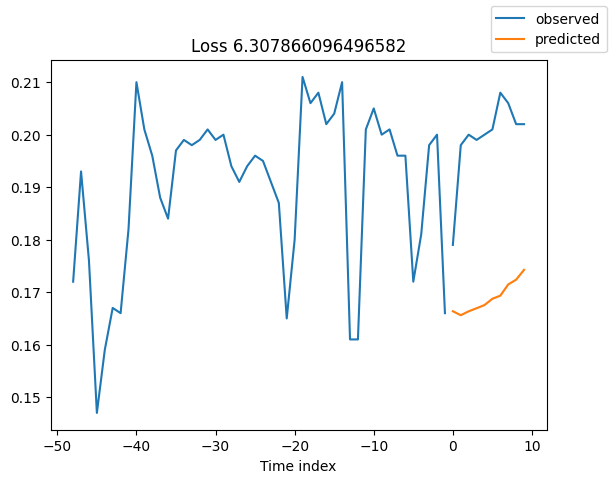

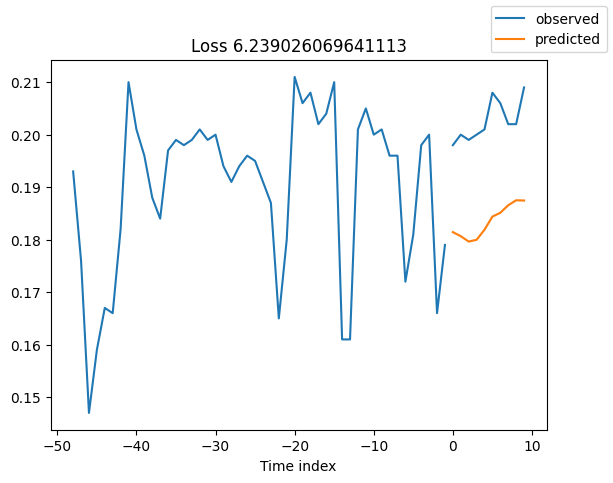

In [16]:
# Some random samples from the val. set
raw_predictions = best_model.predict(val_dataloader, mode="raw",
                                     return_x=True,
                                     trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_saved_datasets"))
for idx in range(10):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output,
                               idx=idx, add_loss_to_title=True)

### Interpretation

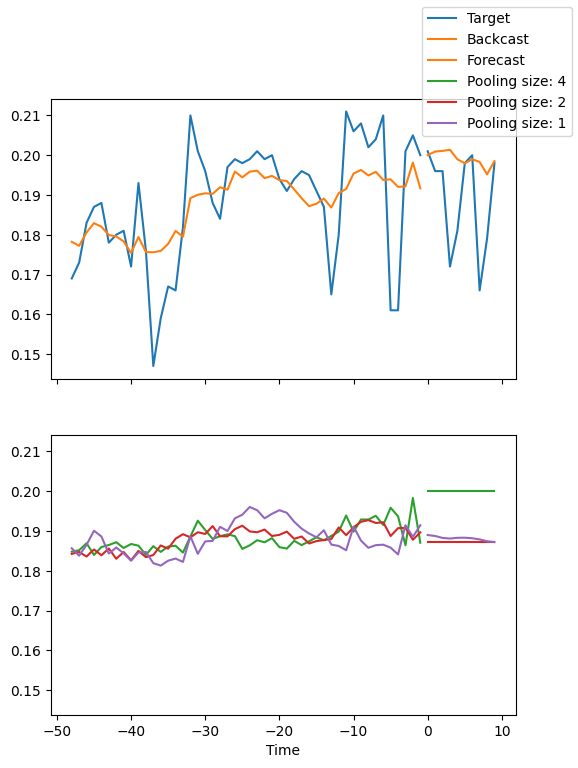

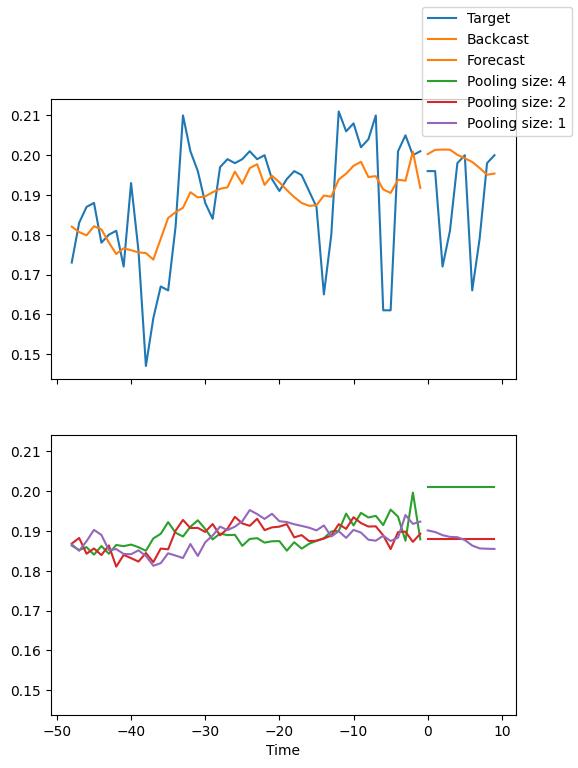

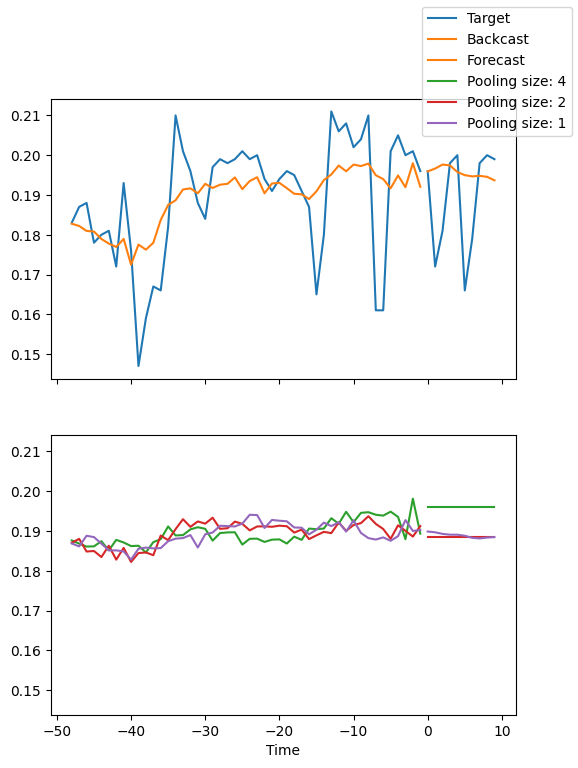

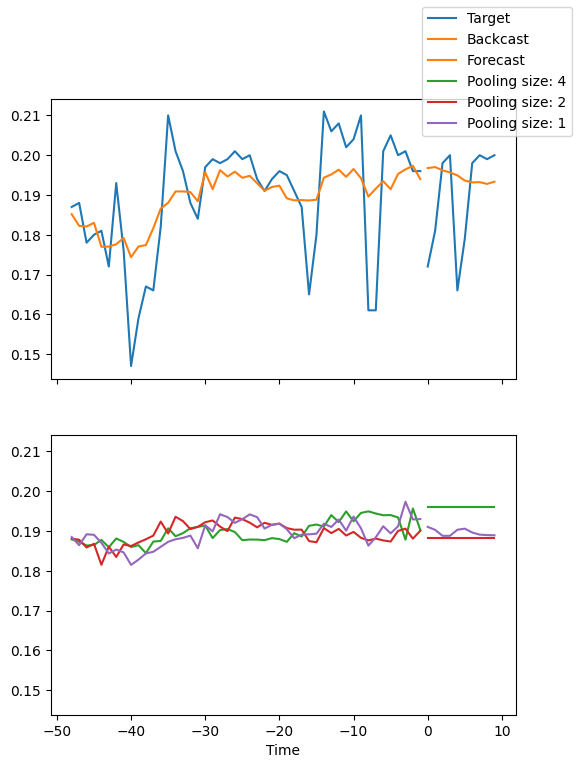

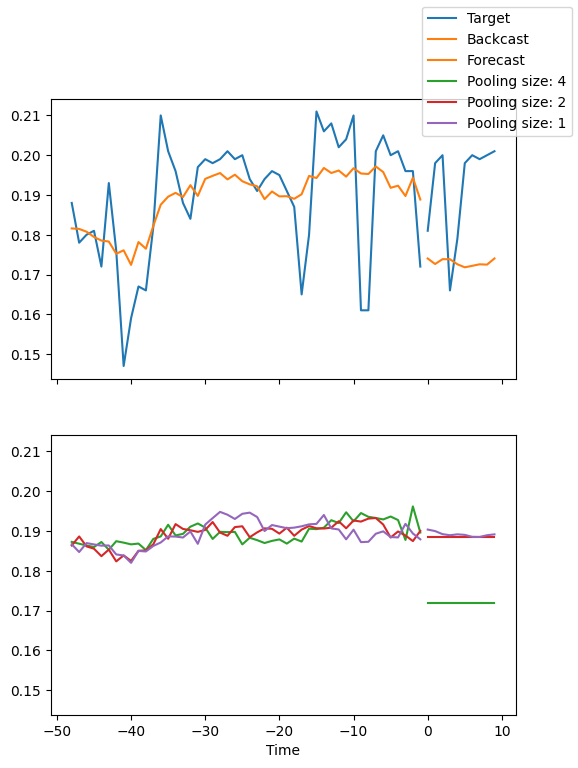

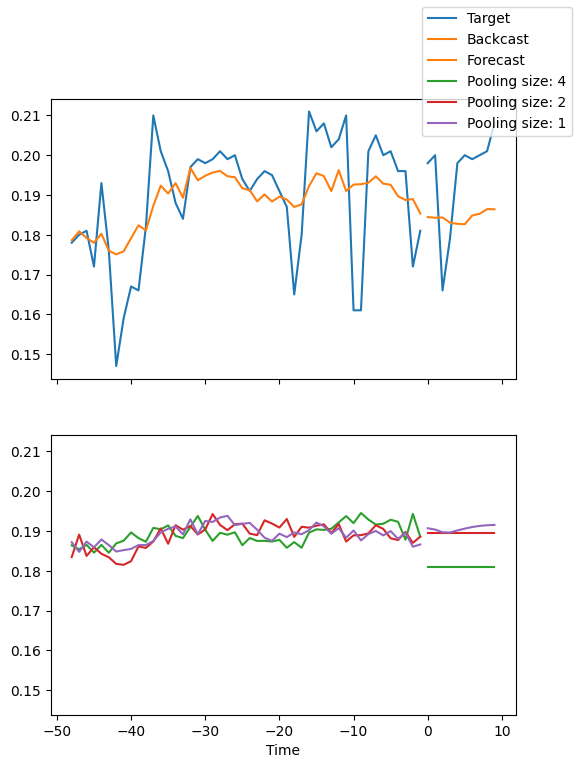

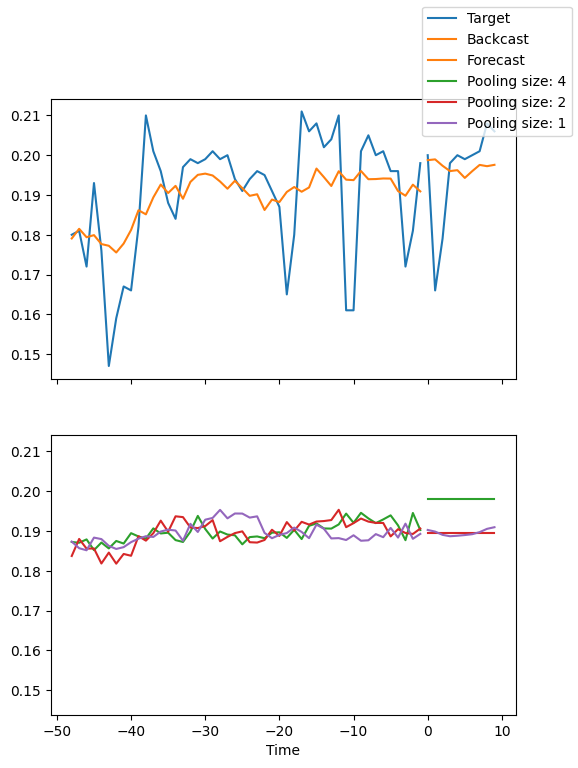

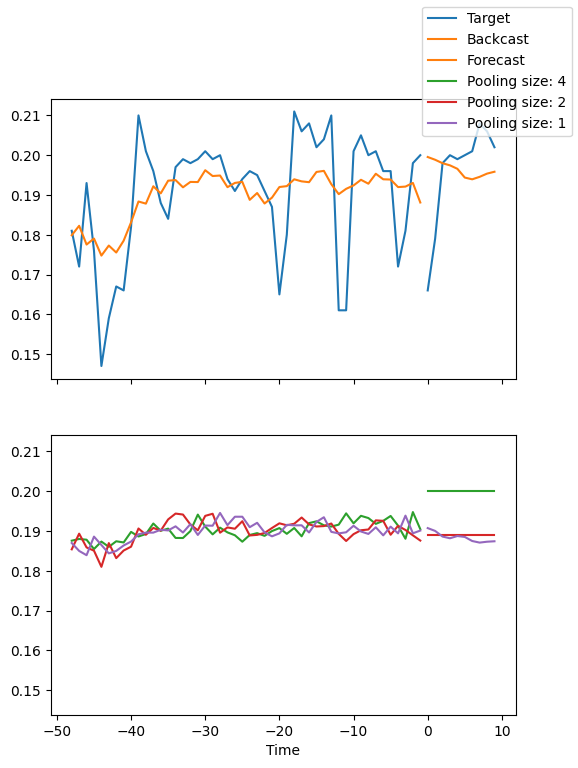

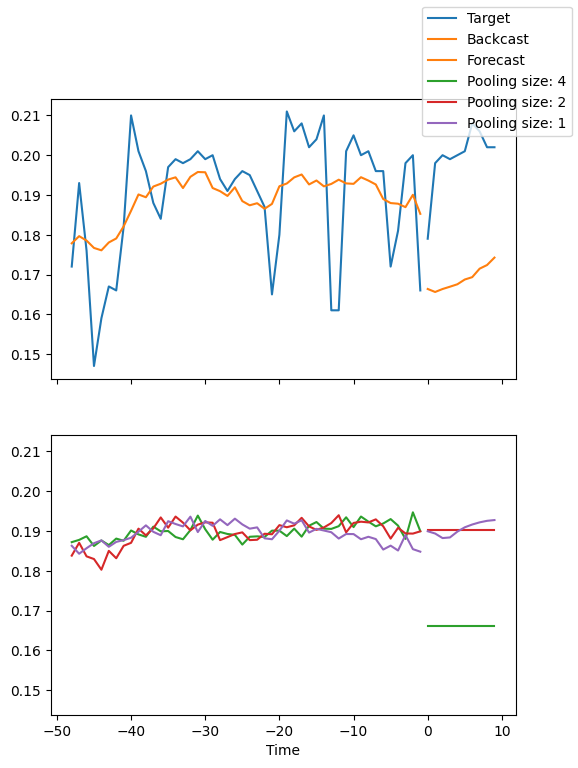

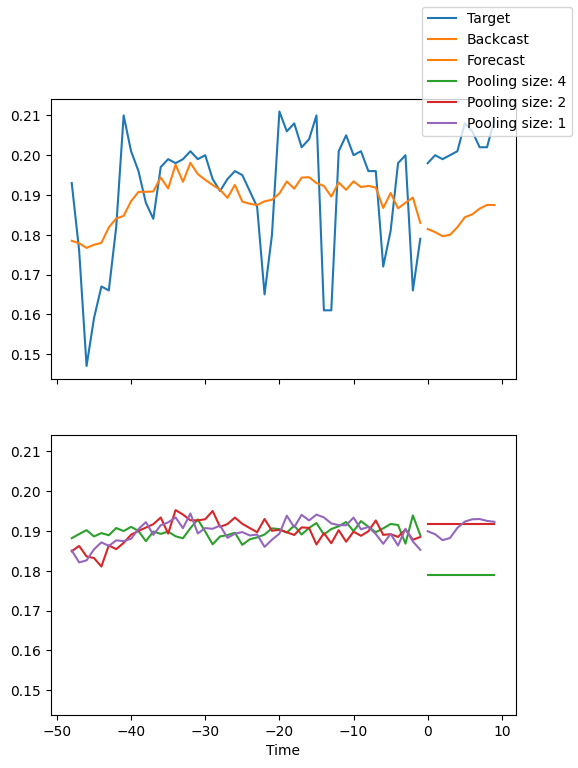

In [17]:
for idx in range(10):
    best_model.plot_interpretation(raw_predictions.x,
                                   raw_predictions.output,
                                   idx=idx)

## NHits with QLoss

### Evaluation

In [14]:
trainer.callback_metrics

{}

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_model = NHiTS.load_from_checkpoint(best_model_path)

./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_QL/lightning_logs/version_2/checkpoints/epoch=99-step=15000.ckpt


In [10]:
#best_model = NHiTS.load_from_checkpoint(...)

In [11]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(torch.device('cuda:0')) # actuals were on CPU per default
predictions = best_model.predict(val_dataloader,
                                 trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_QL"))
(actuals - predictions).abs().mean()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(1.7085, device='cuda:0')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


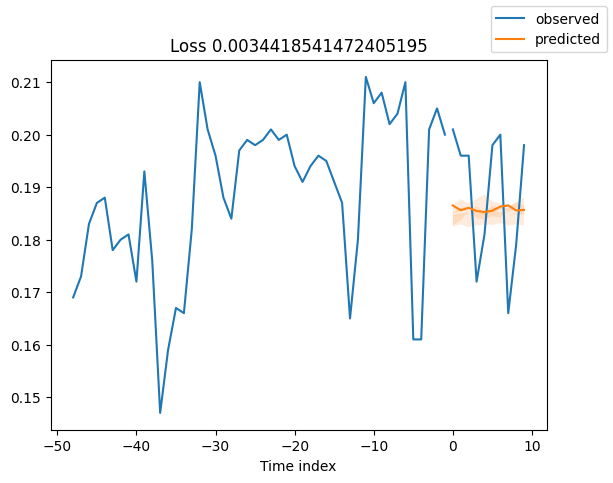

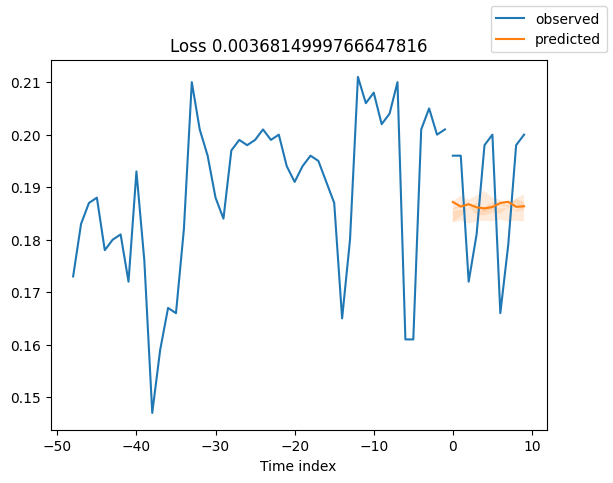

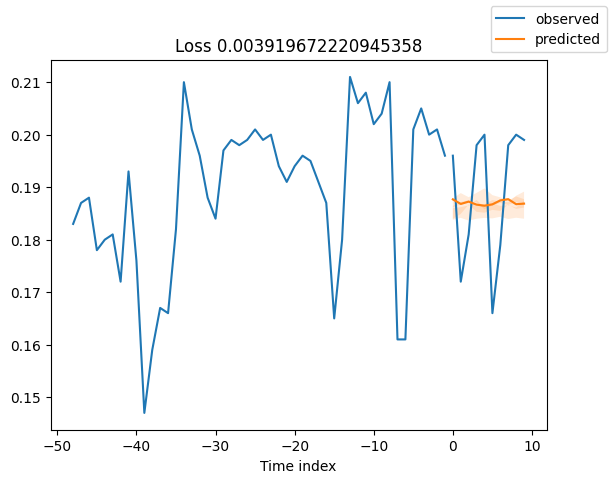

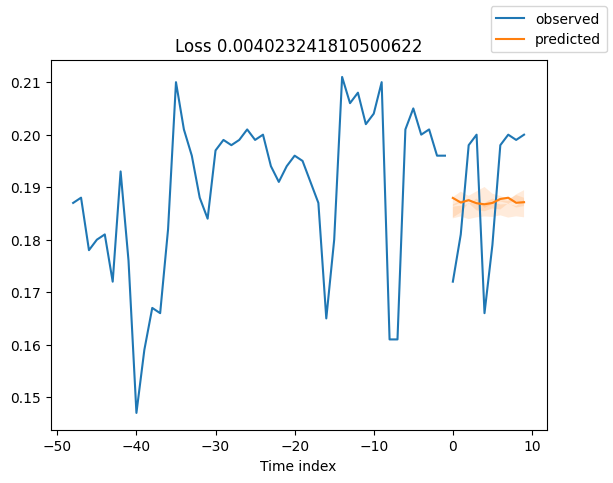

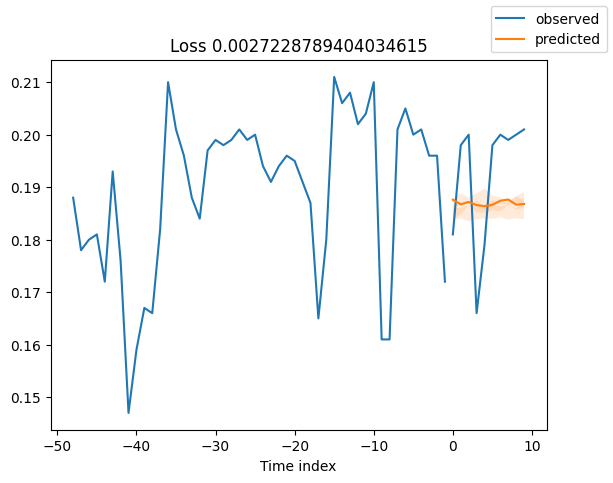

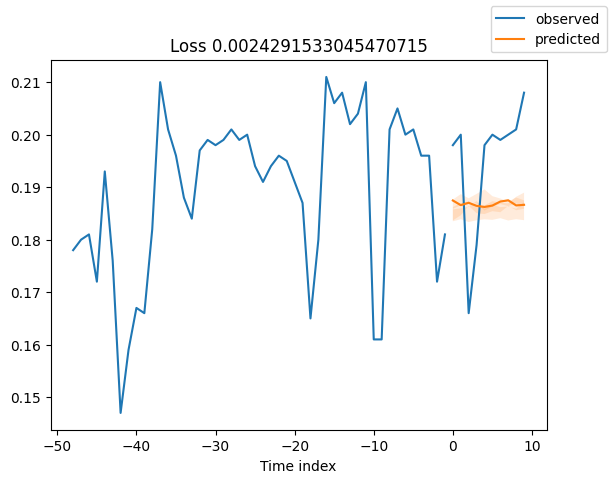

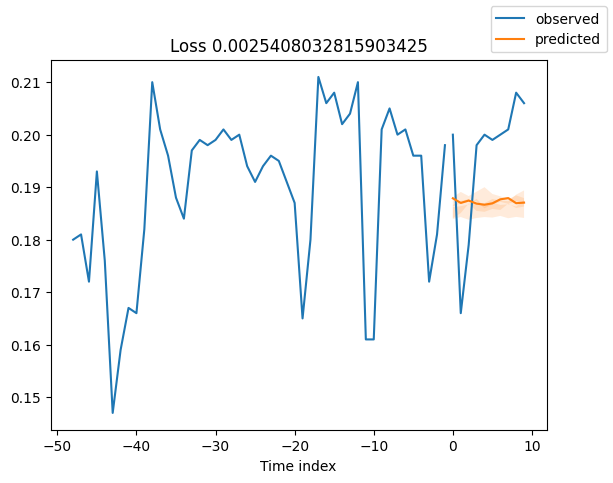

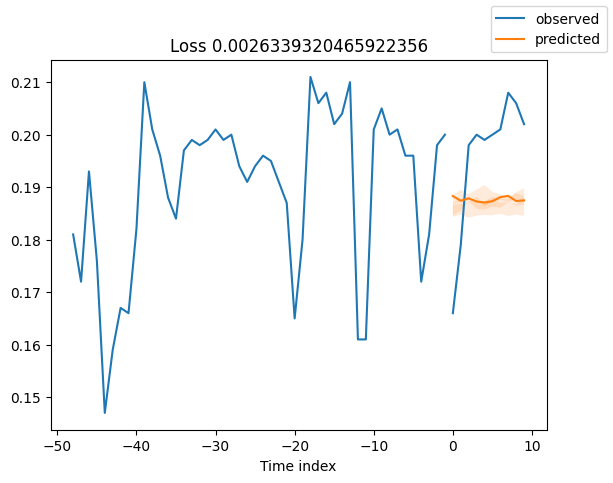

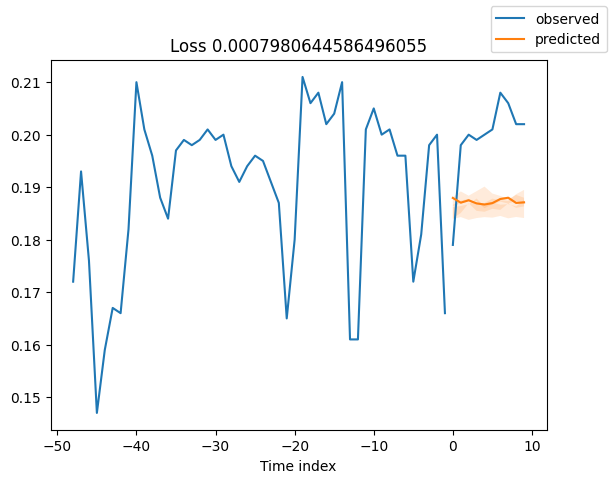

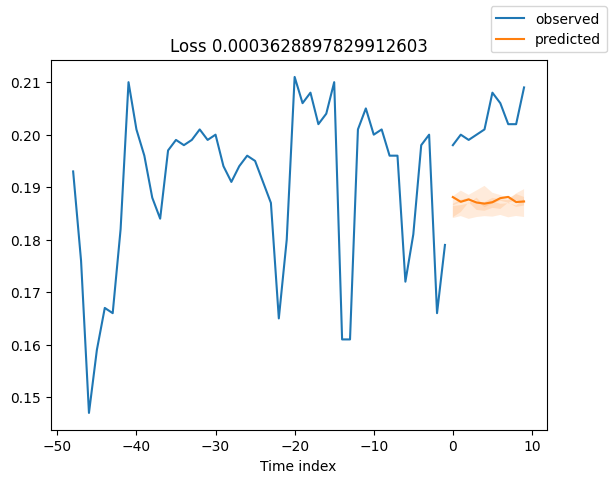

In [12]:
# Some random samples from the val. set
raw_predictions = best_model.predict(val_dataloader, mode="raw",
                                     return_x=True,
                                     trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_QL"))
for idx in range(10):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output,
                               idx=idx, add_loss_to_title=True)

### Interpretation

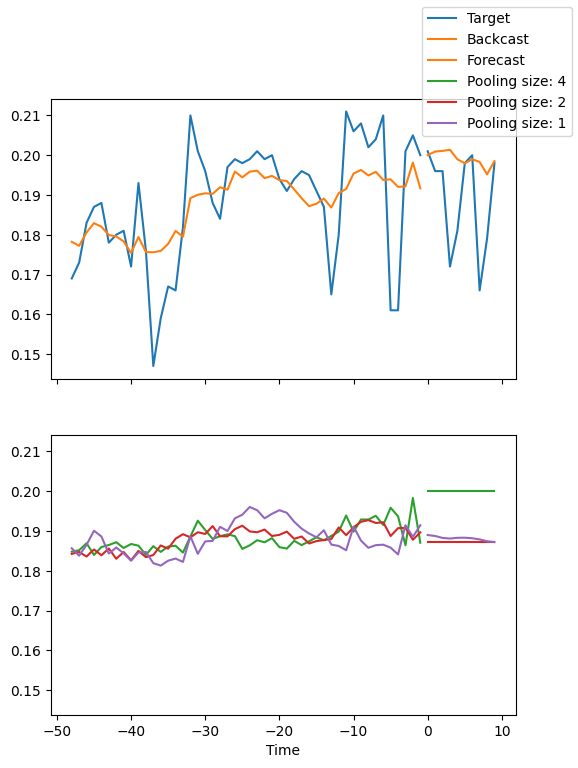

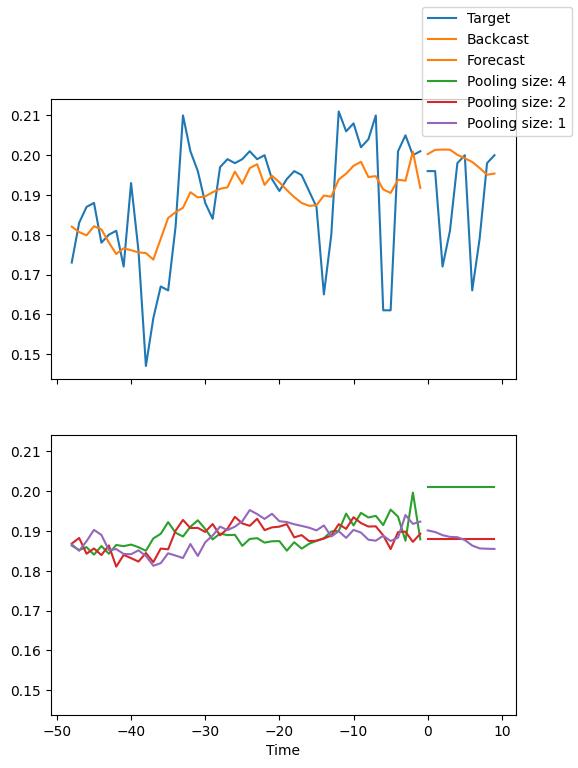

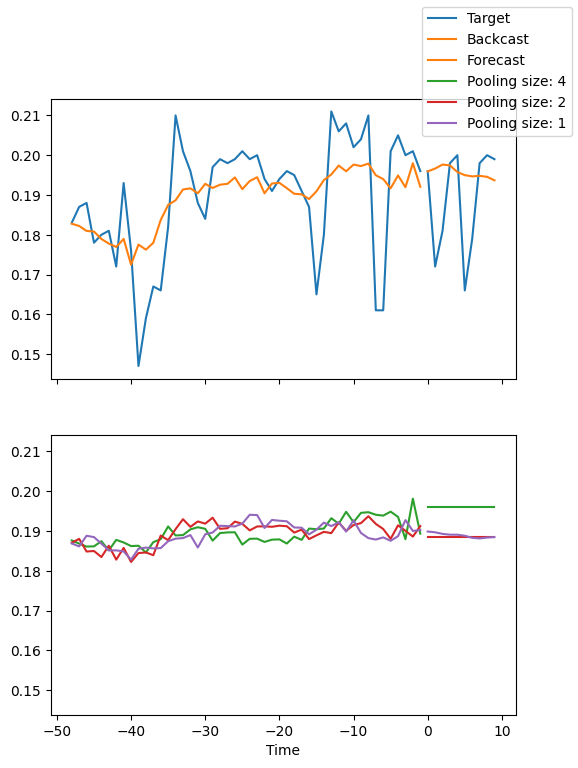

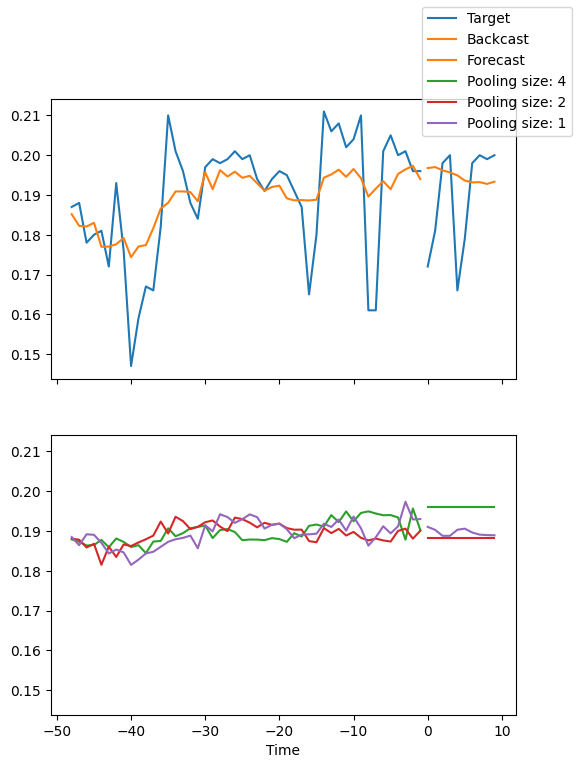

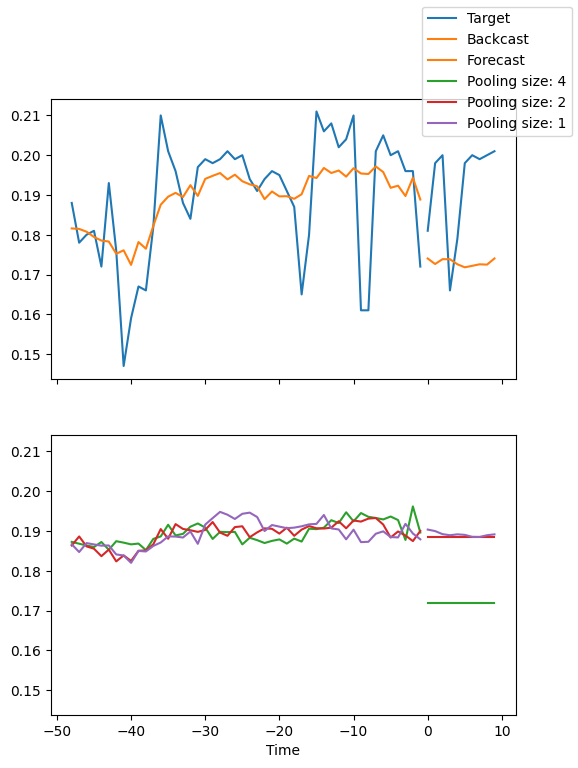

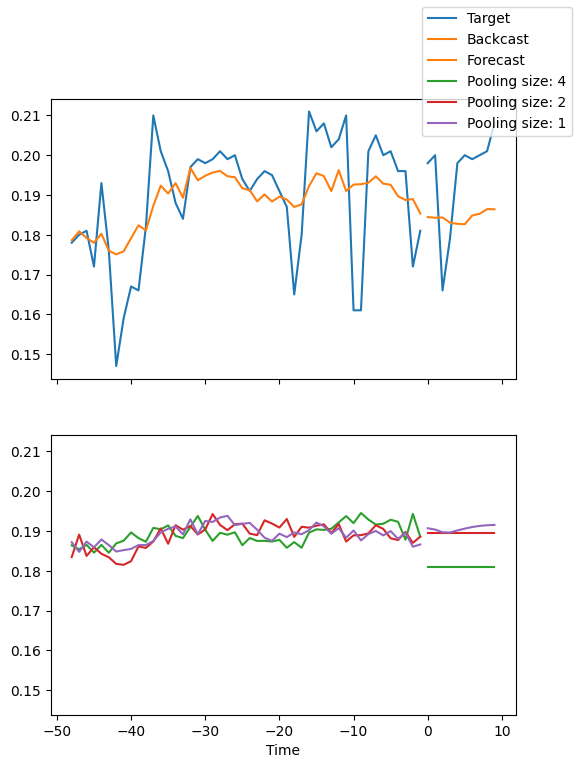

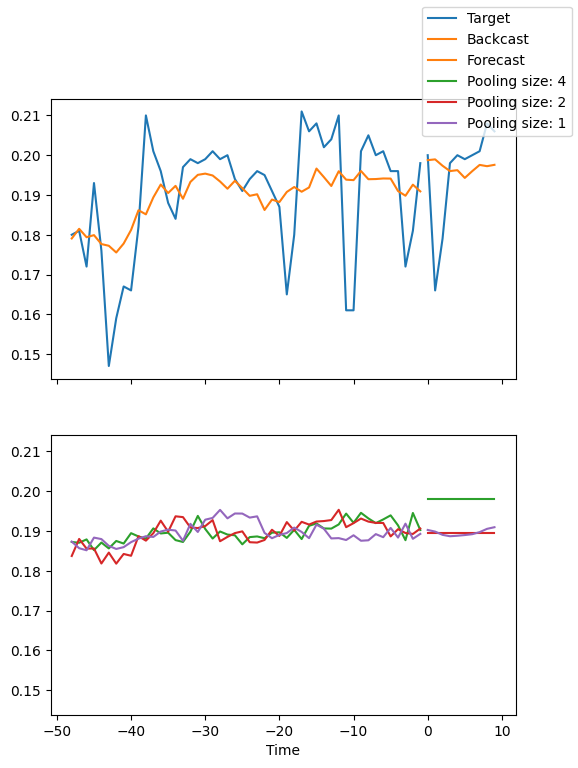

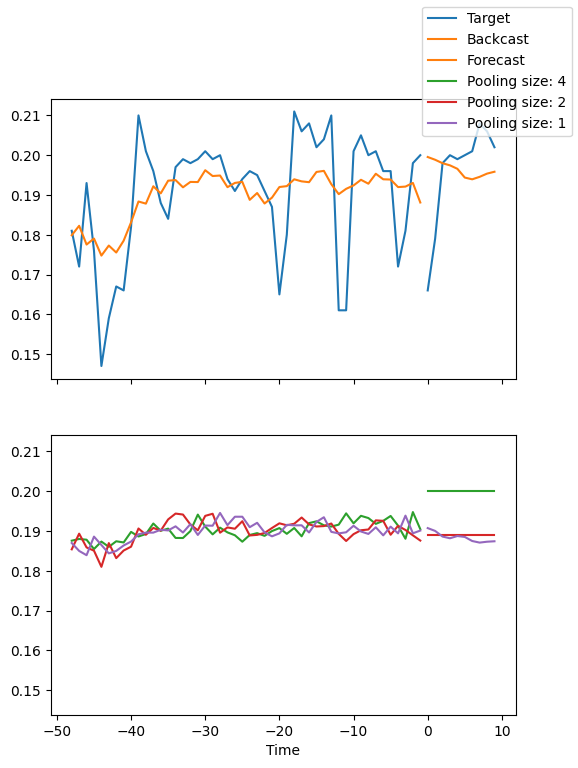

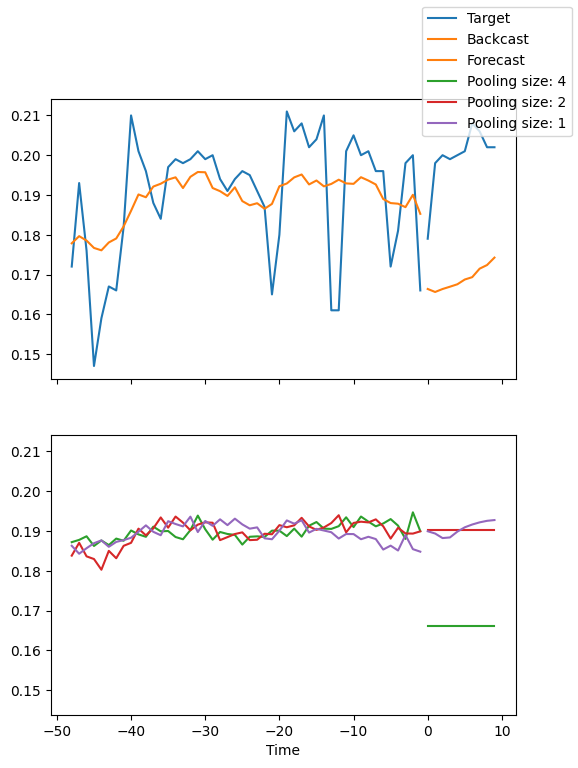

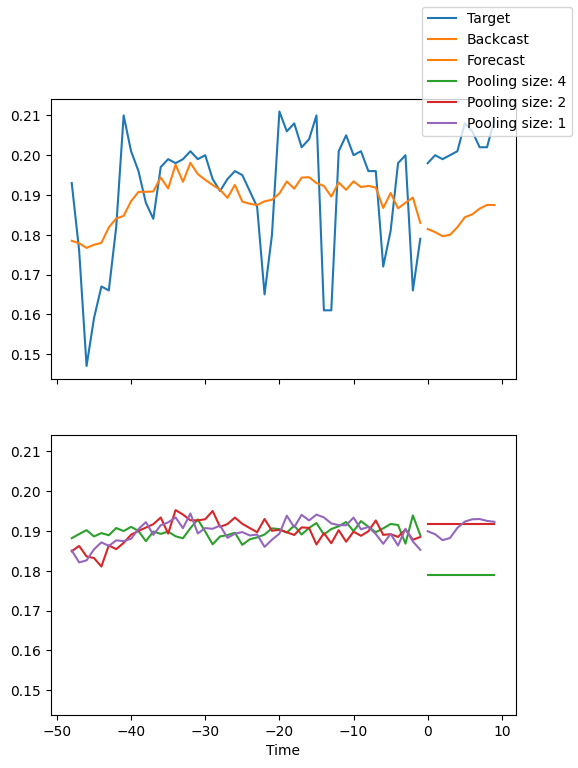

In [18]:
for idx in range(10):
    best_model.plot_interpretation(raw_predictions.x,
                                   raw_predictions.output,
                                   idx=idx)